In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-07-22 13:35:59.936881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 13:35:59.962004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 13:35:59.987701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 13:35:59.994801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 13:36:00.016674: I tensorflow/core/platform/cpu_feature_guar

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
now = datetime.datetime.now

batch_size = 10
# length of data sequences
n_timesteps = 240
# dimension of data sequences
n_dim = 117

(90, 240, 117) correct sequences
(90, 240, 117) incorrect sequences


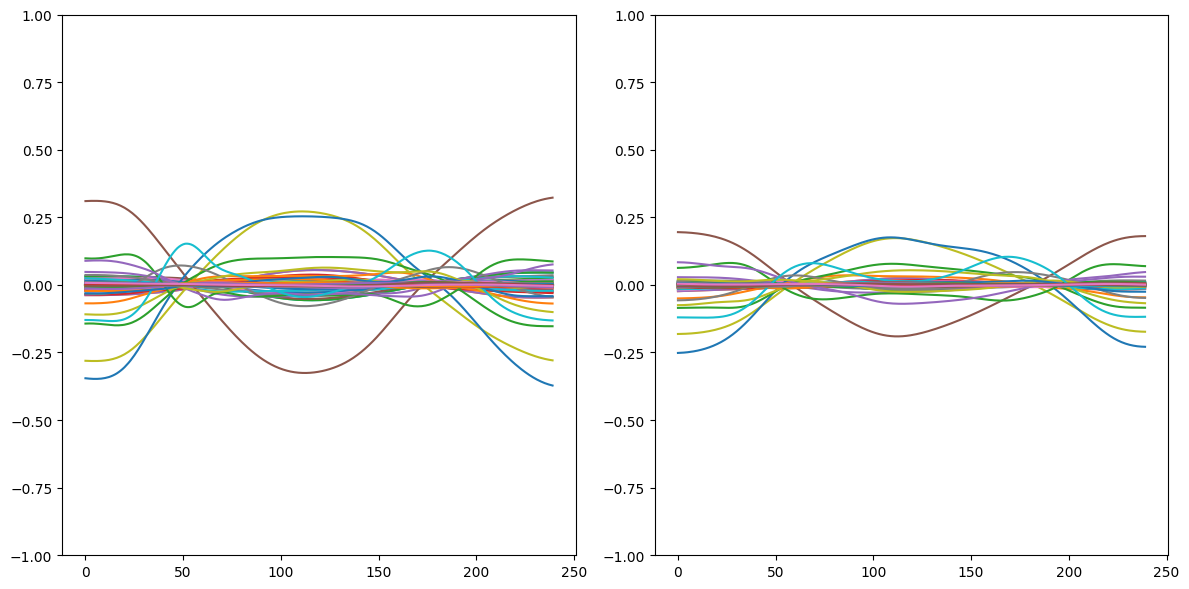

In [16]:
import DataViconLoad
X_correct, X_incorrect = DataViconLoad.load_data()

print(X_correct.shape, 'correct sequences')
print(X_incorrect.shape, 'incorrect sequences')

# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(X_correct[0])
plt.ylim([-1,1])
plt.subplot(1,2,2)
plt.plot(X_incorrect[0])
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

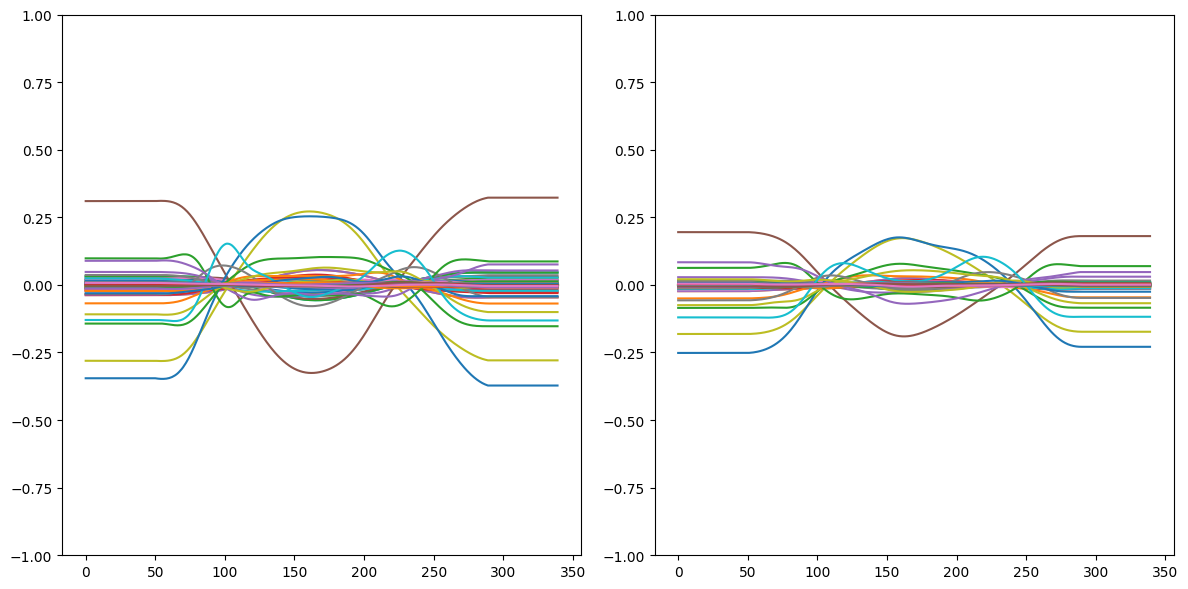

In [17]:
data_correct = np.zeros((X_correct.shape[0],n_timesteps+100,n_dim))
for i in range(X_correct.shape[0]):
    data_correct[i,:,:] = np.concatenate((np.concatenate((np.tile(X_correct[i,0,:],[50, 1]), X_correct[i,:,:])), np.tile(X_correct[i,-1,:],[50, 1])))

data_incorrect = np.zeros((X_incorrect.shape[0],n_timesteps+100,n_dim))
for i in range(X_incorrect.shape[0]):
    data_incorrect[i,:,:] = np.concatenate((np.concatenate((np.tile(X_incorrect[i,0,:],[50, 1]), X_incorrect[i,:,:])), np.tile(X_incorrect[i,-1,:],[50, 1])))
    
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(data_correct[0])
plt.ylim([-1,1])
plt.subplot(1,2,2)
plt.plot(data_incorrect[0])
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

In [18]:
input_seq = Input(shape=(n_timesteps+100,n_dim))
encoded1 = LSTM(30,return_sequences = True)(input_seq)
encoded2 = LSTM(10,return_sequences = True)(encoded1)
# Encoded representation of the input, 340x4 vector
encoded = LSTM(4,return_sequences = True)(encoded2)
# Decoder layers
decoded1 = LSTM(10,return_sequences = True)(encoded)
decoded2 = LSTM(30,return_sequences = True)(decoded1)
decoded = LSTM(n_dim, return_sequences = True)(decoded2)

# The model maps an input to its reconstruction
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 340, 117)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 340, 30)        │        17,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 340, 10)        │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 340, 4)         │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 340, 10)        │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 340, 30)        │         4,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 340, 117)       │        69,264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,424 (368.84 KB)

 Trainable params: 94,424 (368.84 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import random
trainidx = random.sample(range(0,data_correct.shape[0]),63)
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
train_data = data_correct[trainidx,:,:]
valid_data = data_correct[valididx,:,:]

In [20]:
# Train an autoencoder on the correct data sequences

# Measure the training time 
t = now()

# Request to stop before reaching the number of epochs if the validation loss does not decrease for 1000 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 1000)

history = autoencoder.fit(train_data, train_data, epochs = 10000, batch_size = batch_size, shuffle=True,
                validation_data=(valid_data, valid_data), verbose = 0, callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

KeyboardInterrupt: 

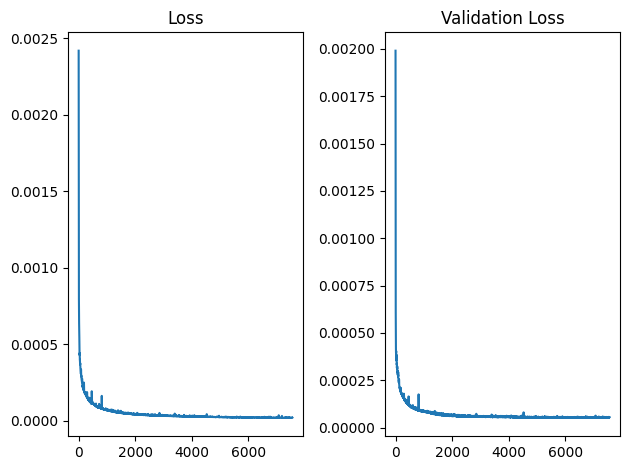

1.8865472156903706e-05
5.582093945122324e-05


In [8]:
# Plot the training and validation results
plt.figure(1)
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the resulting training and validation loss values
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


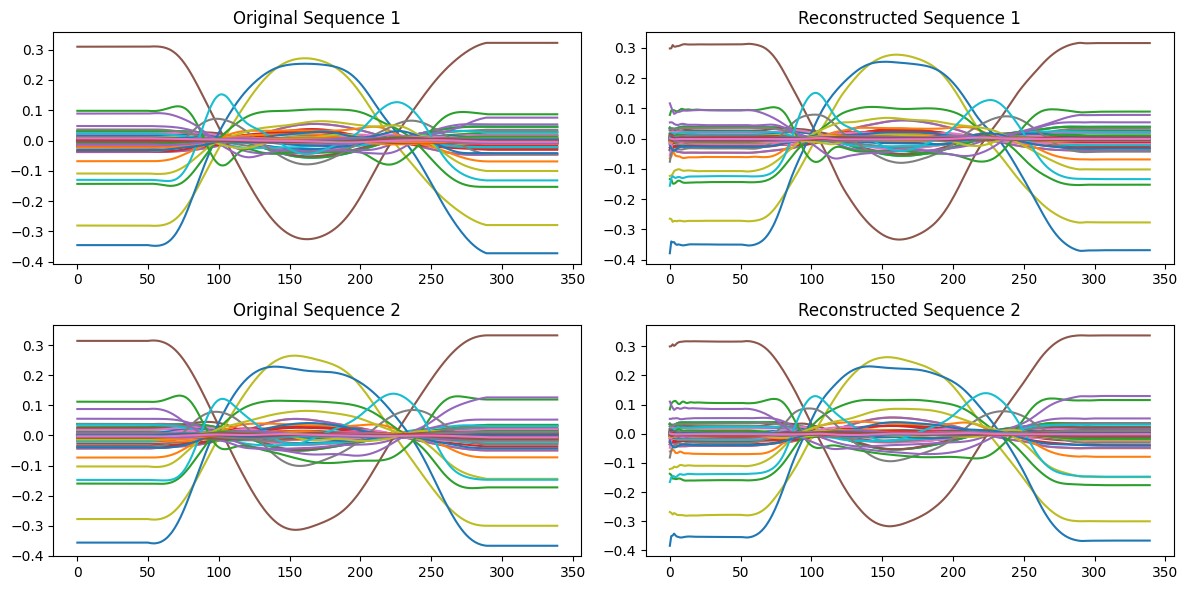

In [9]:
# Encode and decode sequences to check the model performance
decoded_seqs = autoencoder.predict(data_correct)
# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    plt.title(f"Original Sequence {i+1}")
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
    plt.title(f"Reconstructed Sequence {i+1}")
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


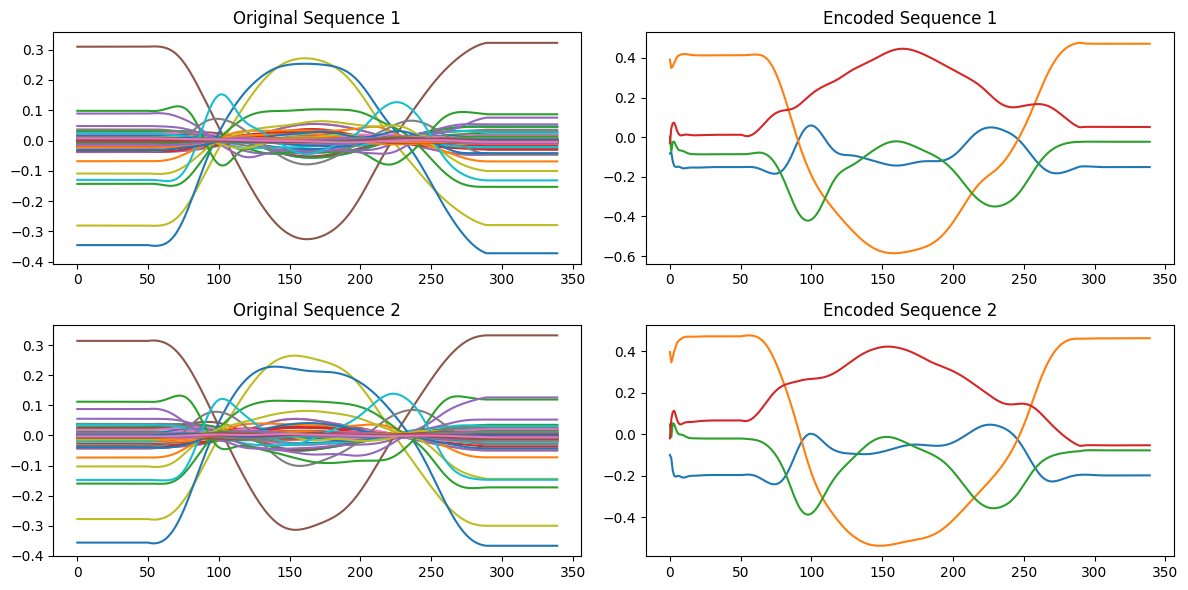

In [10]:
# Create an encoder model, that maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(data_correct)

# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])
    plt.title(f"Original Sequence {i+1}")
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
    plt.title(f"Encoded Sequence {i+1}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2064/1442812958.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,1)
/tmp/ipykernel_2064/1442812958.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,2)
/tmp/ipykernel_2064/1442812958.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

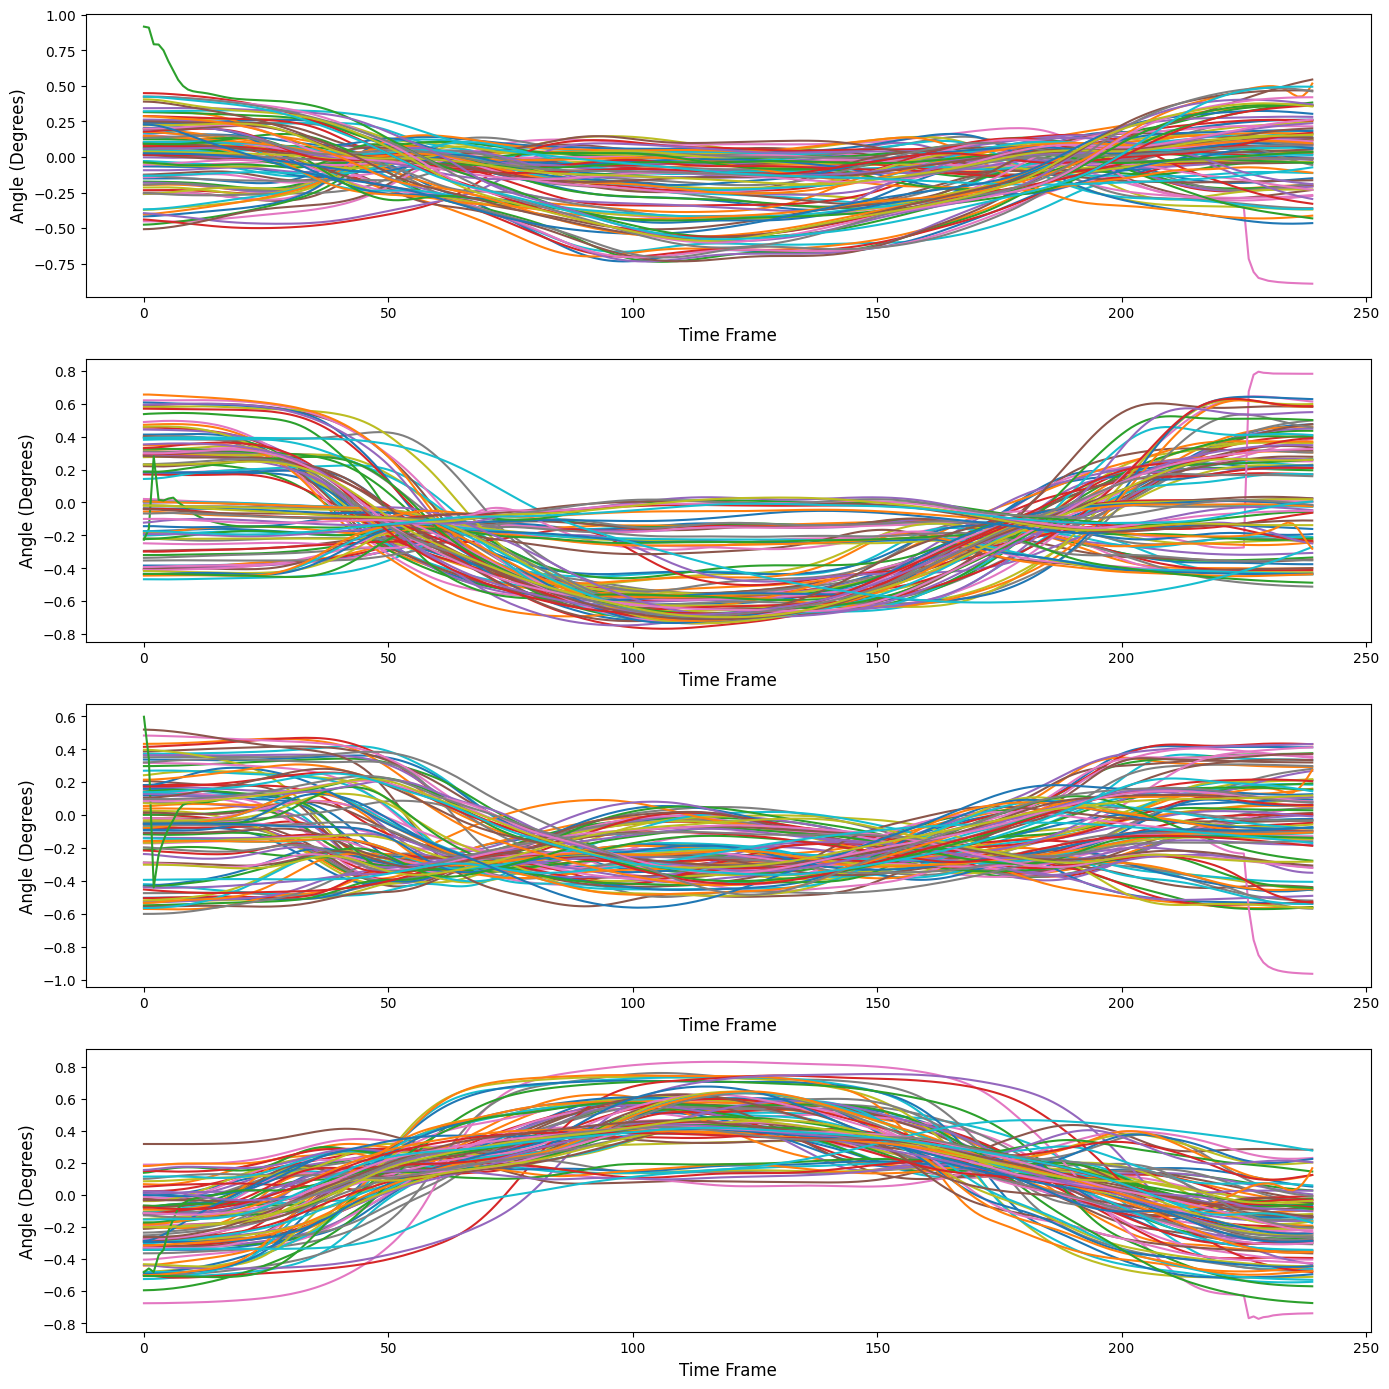

In [11]:
# Plot all encoded sequences without the first and last 50 time frames
plt.figure(figsize = (14,14))
for i in range(data_correct.shape[0]):
    plt.subplot(4,1,1)
    plt.plot(encoded_seqs[i,50:-50,0])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,2)
    plt.plot(encoded_seqs[i,50:-50,1])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,3)
    plt.plot(encoded_seqs[i,50:-50,2])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,4)
    plt.plot(encoded_seqs[i,50:-50,3])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Remove the added first and last 50 frames 
encoded_seqs = encoded_seqs[:,50:-50,:]

print(encoded_seqs.shape, 'encoded sequences shape')
# Reshape the encoded sequences, because savetxt saves two dimensional data
seqs = encoded_seqs.reshape(encoded_seqs.shape[0],encoded_seqs.shape[1]*encoded_seqs.shape[2])
print(seqs.shape, 'encoded sequences shape for saving')
# Save the data in the file 'Autoencoder_Output_Correct.csv'
np.savetxt('/root/autodl-tmp/data/Autoencoder_Output_Correct_m02.csv', seqs, fmt='%.5f',delimiter=',')

(90, 240, 4) encoded sequences shape
(90, 960) encoded sequences shape for saving


In [13]:
encoded_seqs_incorrect = encoder.predict(data_incorrect)
# Remove the added first and last 50 frames 
encoded_seqs_incorrect = encoded_seqs_incorrect[:,50:-50,:]

print(encoded_seqs_incorrect.shape, 'encoded incorrect sequences shape')
# Reshape the encoded sequences, because savetxt saves only tow dimensional data
seqs_incorrect = encoded_seqs_incorrect.reshape(encoded_seqs_incorrect.shape[0],encoded_seqs_incorrect.shape[1]*encoded_seqs_incorrect.shape[2])
print(seqs_incorrect.shape, 'encoded incorrect sequences shape for saving')
# Save the incorrect data in the file 'Autoencoder_Output_Incorrect.csv'
np.savetxt('/root/autodl-tmp/data/Autoencoder_Output_Incorrect_m02.csv', seqs_incorrect, fmt='%.5f',delimiter=',')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(90, 240, 4) encoded incorrect sequences shape
(90, 960) encoded incorrect sequences shape for saving


Epoch 1/10


I0000 00:00:1721634803.015997    2719 service.cc:146] XLA service 0x7fad6c42a730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721634803.016087    2719 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 D, Compute Capability 8.9
2024-07-22 15:53:23.072120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7119

I0000 00:00:1721634804.180295    2719 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.7106
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7005
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6955
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6981 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6968
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6942
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6948
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6927
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6941
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6938 
